In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
import forward


from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model


## Translated forward model from matlab files

In [11]:
# Layout -------L-------
#           ---l---
## A        M       N       B
#  ---r1--
#          --------r2-------
#  --------r3-------
#                    ---r4--

In [12]:
# Setup starting model and initial guess
params=[200, 500, 300, 100, 1, 3, 2]
b_0 = [250, 490, 250, 200, 1.5, 4, 1]

# Make your measurements
number_of_measurements=100
L = np.logspace(0.1, 3, number_of_measurements) 
l = 0.01*L 

#Schlumberger Geometry 
r1 = L-l  
r2 = L+l  
r3 = L+l   
r4 = L-l  

# Get the simulated data
rho_semu = forward.ves_forward(params, L)

# SimPeg Forward Model

## Forward Simulation - Example from generated data from matlab code

In [5]:
# Layout -------L-------
#           ---l---
## A        M       N       B
#  ---r1--
#          --------r2-------
#  --------r3-------
#                    ---r4--

In [7]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=100
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations = 0.01 * a_b_electrode_separations 

# AB Half electrode spacing
half_electrode_spacing= [250, 490, 250, 200, 1.5, 4, 1]


source_list = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

In [8]:
# Define layer thicknesses.
layer_thicknesses = np.r_[1, 3, 2]

# Define layer resistivities.
model = np.r_[200, 500, 300, 100]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [9]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

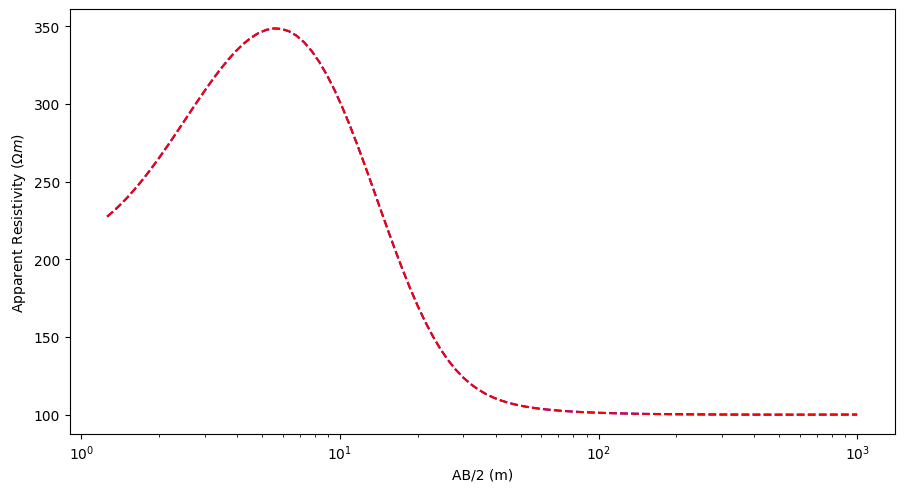

In [13]:
# Predict data for a given model
dpred = simulation.dpred(model)

# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.plot(a_b_electrode_separations, dpred, "b--")
ax1.plot(a_b_electrode_separations, rho_semu, "r--")
ax1.plot()
ax1.set_xscale('log')
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.show()



## Forward Simulation - Textbook example

In [63]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=19
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations = 0.01 * a_b_electrode_separations 

source_list = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

In [20]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [225]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Predict data for a given model
dpred = simulation.dpred(model)

ValueError: Dimension mismatch in IdentityMap(11,11) and np.ndarray(3,).

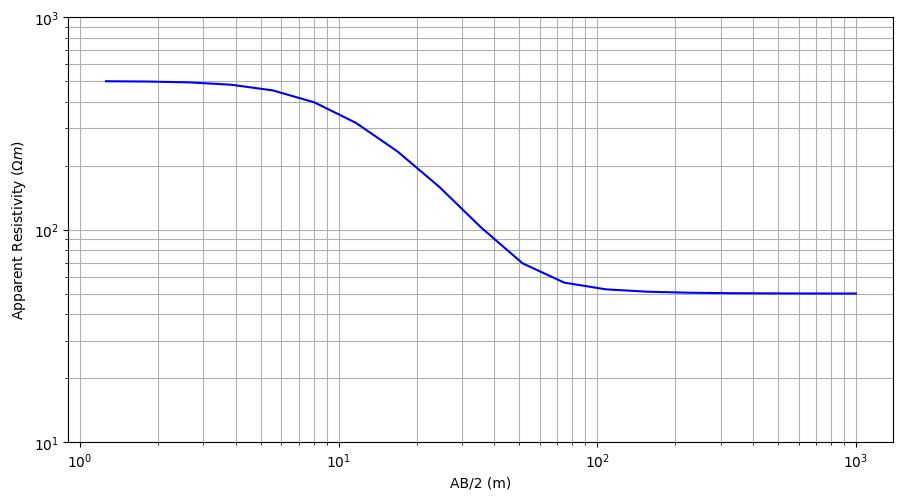

In [182]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog( a_b_electrode_separations, dpred, "b")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


## Inversion of Sounding Data - Textbook example
## Least Squares 1D Inversion

In [152]:
import os

from discretize import TensorMesh

In [141]:
std = 0.02 * np.abs(dpred)
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [142]:
# Define layer thickness
layer_thicknesses =  np.logspace(0, 0.3, 10)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

In [143]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

In [144]:
# Define the physics of the problem using the Simulation1DLayers class.
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [145]:
# Use L2 norm for data misfit of the weighted residual between observed and predicted
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)


# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [146]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [147]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.28e+05  9.28e+04  0.00e+00  9.28e+04    2.29e+05      0              
   1  1.28e+05  3.20e+04  1.76e-01  5.44e+04    2.57e+04      0              
   2  1.28e+05  3.44e+04  1.40e-01  5.22e+04    3.20e+03      0              
   3  2.55e+04  3.36e+04  1.45e-01  3.73e+04    7.64e+04      0              
   4  2.55e+04  8.94e+03  6.09e-01  2.45e+04    5.48e+03      0              
   5  2.55e+04  1.03e+04  5.52e-01  2.43e+04    1.69e+03      0              
   6  5.10e+03  9.72e+03  5.72e-01

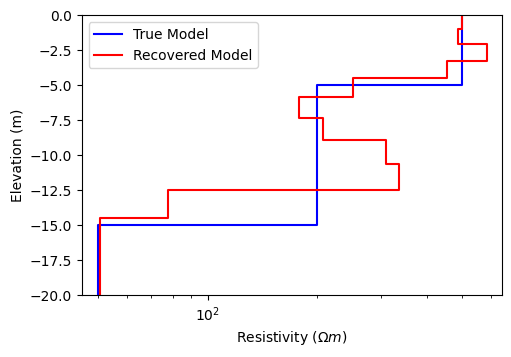

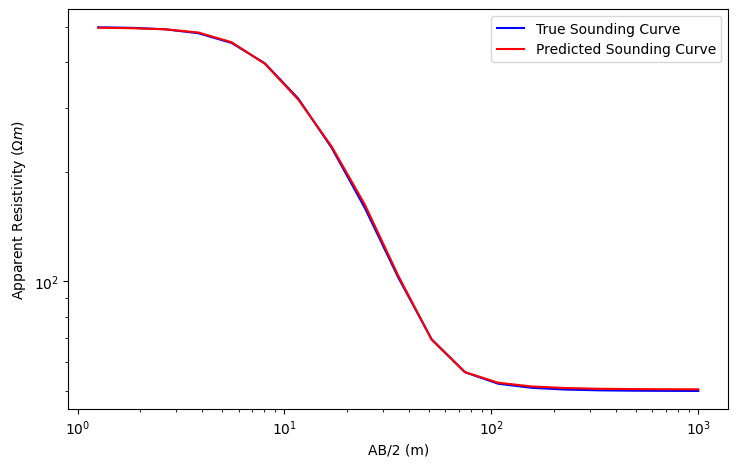

In [151]:
# Define true model and layer thicknesses
true_model = np.r_[500, 200, 50]
true_thickness = np.r_[5.0, 10.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(6, 4))
x_min = np.min([np.min(model_map * recovered_model), np.min(model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thickness, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.set_ylim(-20, 0)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations, dpred, "b")
ax1.loglog(electrode_separations, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()

## Use SBI for Inversion - Textbook example

In [196]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

In [205]:
num_dim = 5
prior_min = torch.as_tensor([0,0,0,0,0])
prior_max = torch.as_tensor([5000,5000,5000, 15, 15])

prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

In [206]:
# Note parameters are composed of resistivities and thicknesses 
def dc_forward(params):
    
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    resistivities = params[:number_of_layers]
    thicknesses = params[number_of_layers:]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [207]:
simulator, prior = prepare_for_sbi(dc_forward, prior)

In [208]:
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)

In [209]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [210]:
inference = inference.append_simulations(theta, x)

In [211]:
density_estimator = inference.train()

 Neural network successfully converged after 155 epochs.

In [212]:
posterior = inference.build_posterior(density_estimator)

In [221]:
posterior_samples = posterior.sample((10000,), x=dpred)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [222]:
posterior_samples

tensor([[4.1731e+02, 3.5059e+03, 6.6206e+01, 2.0653e+00, 8.9385e+00],
        [6.0953e+02, 1.5995e+03, 1.2339e+02, 8.2509e+00, 1.0361e+01],
        [3.8340e+02, 3.9591e+03, 1.1601e+02, 5.5428e+00, 8.2124e+00],
        ...,
        [4.9550e+02, 2.0875e+03, 1.0978e+01, 1.2246e+01, 5.3297e+00],
        [5.4558e+02, 4.2254e+03, 2.8952e+02, 1.1038e+01, 1.1172e+01],
        [5.5243e+02, 2.2600e+02, 3.7481e+02, 1.1720e+01, 1.0965e+01]])

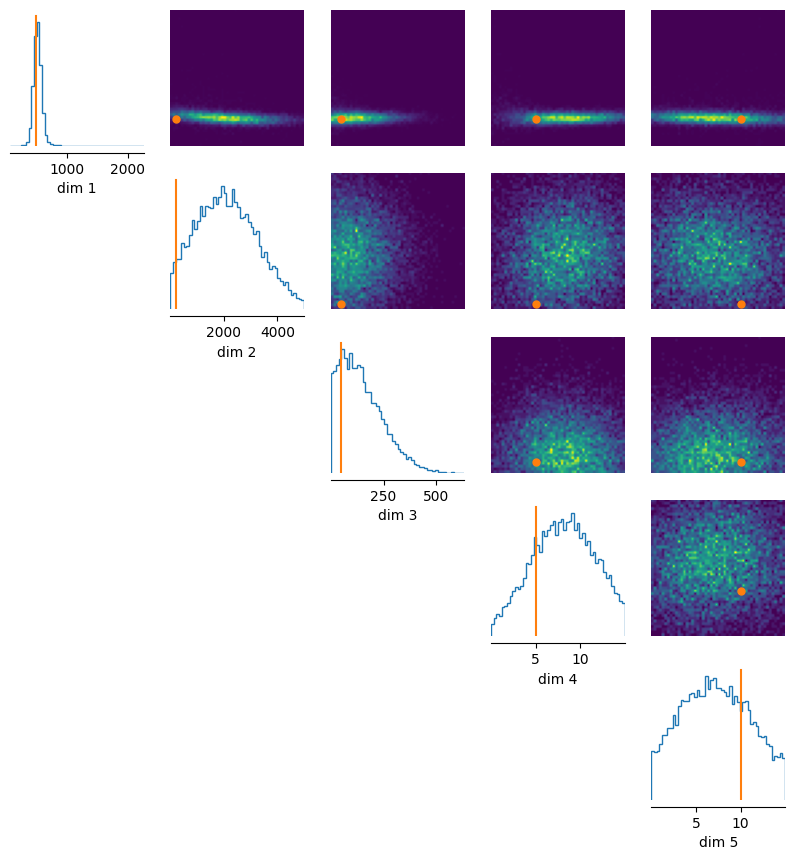

In [226]:
# plot posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50, 5, 10]))

In [ ]:
# From the posterior check the sounding curves and see how they look like. 
# 
#
